In [21]:
import pandas as pd
import yfinance as yf
import numpy as np
from hurst import compute_Hc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from src import (data_loader, processing, feature_engineering, clustering, modeling)
from src.clustering import core

In [22]:
df = data_loader.download_raw_data(start_date='2000-01-01', end_date='2025-12-31')
df_processed = processing.prepare_market_data(df)
df_with_features = feature_engineering.add_spx_vix_features(df_processed)
features = core.DEFAULT_FEATURE_COLS
df_features = core.build_feature_matrix(df_with_features, features)
x_scaled, scaler = core.scale_features(df_features[0])
X_pca_reduced, n_components, pca = core.pca_analysis(x_scaled, variance_target=0.9)
labels, kmeans_model = core.fit_kmeans(X_pca_reduced, n_clusters=2 , random_state=42)
df_assigned = core.assign_cluster_labels(df_with_features, df_features[1], labels, "KMeans_Regime")

C:\Users\leogo\PycharmProjects\FinalProject\src\data_loader.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\leogo\PycharmProjects\FinalProject\src\data_loader.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [23]:
df_sup, X_all, y_all = modeling.build_supervised_dataset(df_assigned, features)

In [45]:
splits = {
    "2010-20 → 2021-24": ("2010-01-01", "2020-12-31", "2021-01-01", "2024-12-31"),
    "2003-15 → 2016-20": ("2003-01-01", "2015-12-31", "2016-01-01", "2020-12-31"),
}

results_df, preds_df = modeling.run_splits(
    df_sup=df_sup,
    X_all=X_all,
    y_all=y_all,
    splits=splits,
)
results_df


=== Running split: 2010-20 → 2021-24 ===
LogisticRegression → acc=0.953, bal_acc=0.960, f1=0.970, auc=0.995
RandomForest → acc=0.948, bal_acc=0.906, f1=0.968, auc=0.989
GradientBoosting → acc=0.949, bal_acc=0.892, f1=0.969, auc=0.994

=== Running split: 2003-15 → 2016-20 ===
LogisticRegression → acc=0.959, bal_acc=0.950, f1=0.974, auc=0.990
RandomForest → acc=0.941, bal_acc=0.934, f1=0.963, auc=0.987
GradientBoosting → acc=0.944, bal_acc=0.925, f1=0.965, auc=0.976


,accuracy,balanced_accuracy,f1,roc_auc,split,model
0,0.953234,0.959892,0.969814,0.995245,2010-20 → 2021-24,LogisticRegression
1,0.948259,0.905590,0.967702,0.988952,2010-20 → 2021-24,RandomForest
2,0.949254,0.892104,0.968654,0.993655,2010-20 → 2021-24,GradientBoosting
3,0.958697,0.950136,0.974308,0.990308,2003-15 → 2016-20,LogisticRegression
4,0.941223,0.934494,0.963147,0.987118,2003-15 → 2016-20,RandomForest
5,0.943606,0.924551,0.964938,0.976009,2003-15 → 2016-20,GradientBoosting


In [46]:
def build_majority_vote(preds_df, split_name):
    """Return a Series with majority-vote regime prediction."""
    df = preds_df[preds_df["split"] == split_name].copy()
    df = df.pivot(index="date", columns="model", values="y_pred")

    # majority vote: if >= 2 say regime 1 -> output 1, else 0
    df["vote"] = (df.sum(axis=1) >= 2).astype(int)
    return df["vote"].sort_index()

# Example:
vote_pred = build_majority_vote(preds_df, "2010-20 → 2021-24")
vote_pred


date
2021-01-04    1
2021-01-05    1
2021-01-06    1
2021-01-07    1
2021-01-08    1
             ..
2024-12-24    1
2024-12-26    1
2024-12-27    1
2024-12-30    1
2024-12-31    1
Name: vote, Length: 1005, dtype: int64

In [47]:
# Extract predictions for Logistic Regression + split "2010-20 → 2021-24"
mask = (
    (preds_df["model"] == "LogisticRegression") &
    (preds_df["split"] == "2010-20 → 2021-24")
)

preds_lr = preds_df[mask].copy().set_index("date").sort_index()

# usable for trading (today’s signal = yesterday’s predicted regime)
#pred_regime_today = preds_lr["y_pred"].shift(1).dropna()
pred_regime_today = vote_pred.shift(1).dropna()
pred_regime_today


date
2021-01-05    1.0
2021-01-06    1.0
2021-01-07    1.0
2021-01-08    1.0
2021-01-11    1.0
             ... 
2024-12-24    1.0
2024-12-26    1.0
2024-12-27    1.0
2024-12-30    1.0
2024-12-31    1.0
Name: vote, Length: 1004, dtype: float64

In [75]:
df_with_regime = df_assigned.copy()

# predicted regime_t available only at t+1 → shift(1)
pred_regime_today = pred_regime_today  # already created earlier
idx = pred_regime_today.index

# Align features & returns
ret        = df_with_regime.loc[idx, "daily_return"]
ret_next   = df_with_regime["daily_return"].shift(-1).loc[idx]  # return t→t+1

ret_20d        = df_with_regime.loc[idx, "20d_return"]
rsi        = df_with_regime.loc[idx, "RSI_20"]
hurst      = df_with_regime.loc[idx, "hurst_100d"]
sma20      = df_with_regime.loc[idx, "slope_MA_20"]
sma50      = df_with_regime.loc[idx, "slope_MA_50"]
vix        = df_with_regime.loc[idx, "VIX_Close"]
ret_5d     = df_with_regime.loc[idx, "5d_return"]
adx        = df_with_regime.loc[idx, "ADX_14"]
vol_ratio  = df_with_regime.loc[idx, "vol_ratio"]

vix_z      = df_with_regime.loc[idx, "VIX_Zscore_20d"]
dd         = df_with_regime.loc[idx, "current_drawdown"]
vrp        = df_with_regime.loc[idx, "VRP_Proxy"]
vol        = df_with_regime.loc[idx, "realized_vol_20d_ann"]

vol_thresh = vol.median()
print(f"Median realized_vol_20d_ann: {vol_thresh}")

reg0 = pred_regime_today == 0
reg1 = pred_regime_today == 1

Median realized_vol_20d_ann: 0.13952469584412897


In [76]:
# Strategy number 1
positions_strat1 = pd.Series(0.0, index=idx)
positions_strat1[reg1] = 1.0

In [136]:
# Strategy number 2
positions_strat2 = pd.Series(0.0, index=idx)

long_mom  = reg1  & (sma50 > 0) & rsi.between(50, 70)
short_mom = reg0  & (sma50 < 0) & rsi.between(30, 40)

positions_strat2[long_mom]  =  1.0
positions_strat2[short_mom] = -1.0

In [137]:
# Strategy number 3 (more complex and iterated a few times)
positions_3A = pd.Series(0.0, index=idx)
positions_3B = pd.Series(0.0, index=idx)

# Strategy 3A: Regime 0 mean-reversion / VRP logic
long_3A  = (dd < -0.05) & (vrp > 0) & (vix_z < 0) & (vix > 30)
short_3A = (vix_z < -1) & (vrp < 0)

positions_3A[reg0 & long_3A]  =  1.0
positions_3A[reg0 & short_3A] = -1.0

# Strategy 3B: Regime 1 long with filters
filter_3B = (vix_z.rolling(5).max() < 2) & (vol_ratio > 0.6)
positions_3B[reg1 & filter_3B] = 1.0

# Combined Strategy 3
positions_strat3 = positions_3A + positions_3B

In [138]:
# Performances
def perf_stats(returns: pd.Series, freq: int = 252):
    """
    Compute standard performance stats + Sortino ratio.

    Sharpe  uses full volatility
    Sortino uses downside deviation only (returns < 0)
    """

    eq = (1 + returns).cumprod()

    mu = returns.mean() * freq
    sigma = returns.std() * np.sqrt(freq)

    # Downside deviation (standard definition)
    downside = returns[returns < 0]
    if len(downside) > 0:
        downside_dev = downside.std() * np.sqrt(freq)
    else:
        downside_dev = np.nan  # no negative returns → undefined Sortino

    sharpe = mu / sigma if sigma > 0 else np.nan
    sortino = mu / downside_dev if downside_dev and downside_dev > 0 else np.nan

    max_dd = (eq / eq.cummax()).min() - 1

    return {
        "ann_return": mu,
        "ann_vol": sigma,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_dd,
    }


# Returns
bh_ret     = ret
strat1_ret = positions_strat1 * ret_next
strat2_ret = positions_strat2 * ret_next
strat3A_ret = positions_3A * ret_next
strat3B_ret = positions_3B * ret_next
strat3_ret  = positions_strat3 * ret_next

# Performance
perf_1  = perf_stats(strat1_ret)
perf_2  = perf_stats(strat2_ret)
perf_3A = perf_stats(strat3A_ret)
perf_3B = perf_stats(strat3B_ret)
perf_3  = perf_stats(strat3_ret)
perf_BH = perf_stats(bh_ret)

print("\nPerformance — Strategy 1 (Regime 1 long-only):\n", perf_1)
print("\nPerformance — Strategy 2 :\n", perf_2)
print("\nPerformance — Strategy 3A (Regime 0 L/S):\n", perf_3A)
print("\nPerformance — Strategy 3B (Regime 1 filtered long):\n", perf_3B)
print("\nPerformance — Strategy 3 Combined:\n", perf_3)
print("\nPerformance — Buy & Hold:\n", perf_BH)


Performance — Strategy 1 (Regime 1 long-only):
 {'ann_return': np.float64(0.10924621154283946), 'ann_vol': np.float64(0.12186601117872009), 'sharpe': np.float64(0.8964452884457397), 'sortino': np.float64(1.132061187402021), 'max_drawdown': np.float64(-0.17284955106453825)}

Performance — Strategy 2 :
 {'ann_return': np.float64(0.09968915797309827), 'ann_vol': np.float64(0.09821695891765166), 'sharpe': np.float64(1.014989255131397), 'sortino': np.float64(0.9959741509043689), 'max_drawdown': np.float64(-0.07600394981111369)}

Performance — Strategy 3A (Regime 0 L/S):
 {'ann_return': np.float64(0.060852897192576194), 'ann_vol': np.float64(0.05494928273138217), 'sharpe': np.float64(1.1074375163376318), 'sortino': np.float64(0.39137038970986615), 'max_drawdown': np.float64(-0.04920666806377516)}

Performance — Strategy 3B (Regime 1 filtered long):
 {'ann_return': np.float64(0.12091359351439457), 'ann_vol': np.float64(0.08937038236128633), 'sharpe': np.float64(1.3529492693182457), 'sortino'

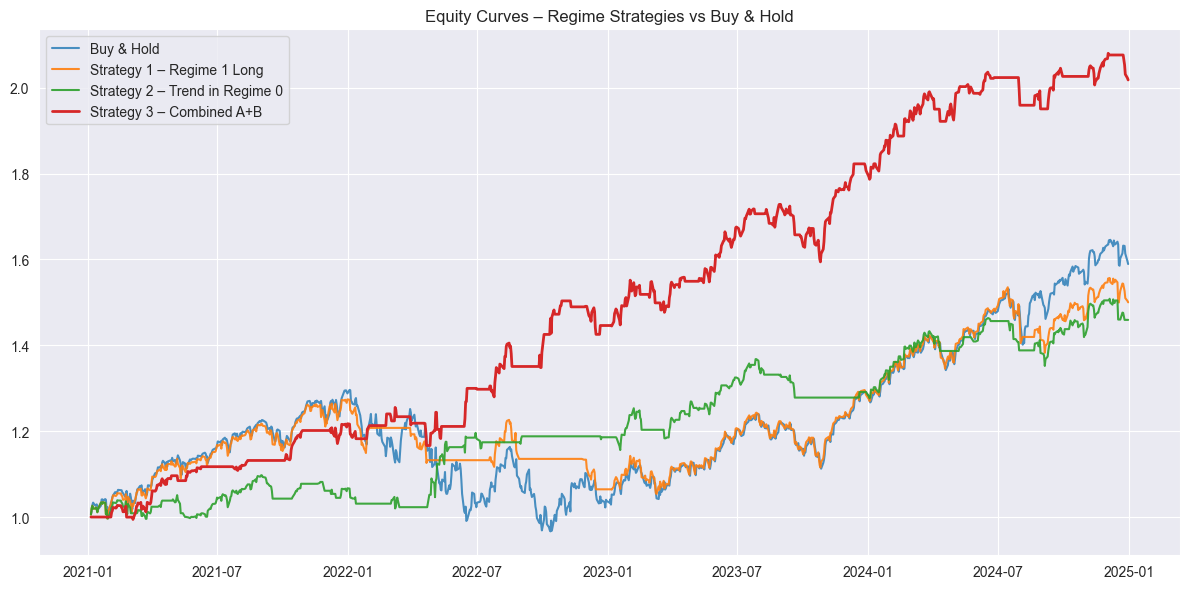

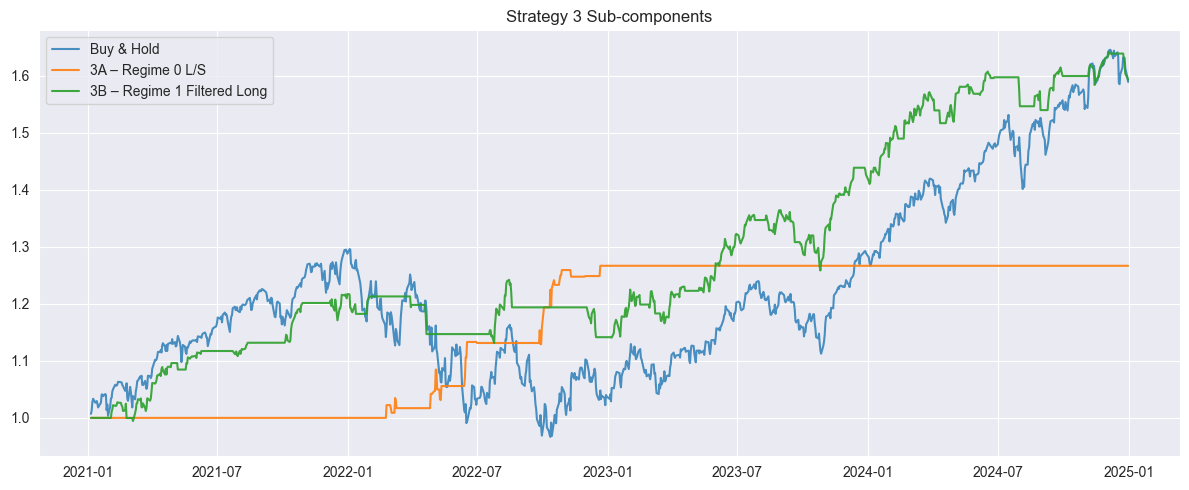

In [139]:
# Equity Curves
eq_BH  = (1 + bh_ret).cumprod()
eq_1   = (1 + strat1_ret).cumprod()
eq_2   = (1 + strat2_ret).cumprod()
eq_3A  = (1 + strat3A_ret).cumprod()
eq_3B  = (1 + strat3B_ret).cumprod()
eq_3   = (1 + strat3_ret).cumprod()

plt.figure(figsize=(12,6))
plt.plot(eq_BH, label="Buy & Hold", alpha=0.8)
plt.plot(eq_1, label="Strategy 1 – Regime 1 Long", alpha=0.9)
plt.plot(eq_2, label="Strategy 2 – Trend in Regime 0", alpha=0.9)
plt.plot(eq_3, label="Strategy 3 – Combined A+B", linewidth=2)
plt.title("Equity Curves – Regime Strategies vs Buy & Hold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Sub-plot for Strategy 3 components
plt.figure(figsize=(12,5))
plt.plot(eq_BH, label="Buy & Hold", alpha=0.8)
plt.plot(eq_3A, label="3A – Regime 0 L/S", alpha=0.9)
plt.plot(eq_3B, label="3B – Regime 1 Filtered Long", alpha=0.9)
plt.title("Strategy 3 Sub-components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()